In [114]:
import matplotlib.pyplot as plt # 3.6
import numpy as np # 1.22.4
import tensorflow as tf # 2.11.0
import gpflow # 2.7.0
import pandas as pd
from tensorflow import keras
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
print('tensorflow ', tf.__version__) 
print('numpy ', np.__version__) 
print('gpflow ', gpflow.__version__) 
print('pandas ', pd.__version__) 

tensorflow  2.11.0
numpy  1.22.4
gpflow  2.7.0
pandas  1.5.3


In [2]:
plt.rcParams["figure.figsize"] = (12, 6)
(X_train, Y_train), (X_test, Y_test) = keras.datasets.boston_housing.load_data()
Y_train = np.atleast_2d(Y_train).T
Y_test = np.atleast_2d(Y_test).T
Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
Y_train = (Y_train - Y_train_mean) / Y_train_std
Y_test = (Y_test - Y_train_mean) / Y_train_std
X_train_2D = X_train[:,4:6].astype('float64')
X_test_2D = X_test[:,4:6].astype('float64')

2023-03-16 10:45:39.249744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


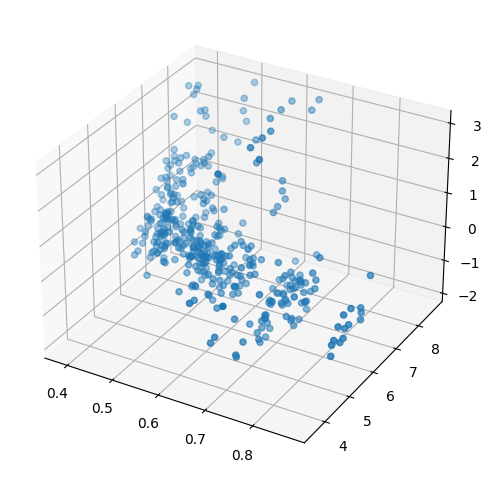

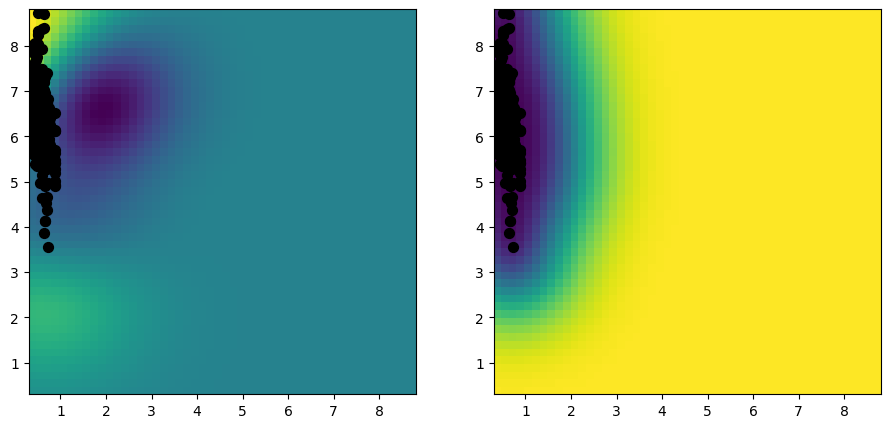

In [3]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_train_2D[:,0], X_train_2D[:,1], Y_train)
def plot_2d_model(model, X, Y):
    n_grid = 50
    _, (ax_mean, ax_std) = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
    Xplots = np.linspace(np.min(X), np.max(X), n_grid)
    Xplot1, Xplot2 = np.meshgrid(Xplots, Xplots)
    Xplot = np.stack([Xplot1, Xplot2], axis=-1)
    Xplot = Xplot.reshape([n_grid ** 2, 2])

    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)

    y_mean, y_var = model.predict_y(Xplot)
    y_mean = y_mean.numpy()
    y_std = tf.sqrt(y_var).numpy()

    ax_mean.pcolor(Xplot1, Xplot2, y_mean.reshape(Xplot1.shape))
    ax_std.pcolor(Xplot1, Xplot2, y_std.reshape(Xplot1.shape))
    ax_mean.scatter(X[:, 0], X[:, 1], s=50, c="black")
    ax_std.scatter(X[:, 0], X[:, 1], s=50, c="black")


model = gpflow.models.GPR(
    (X_train_2D, Y_train),
    kernel=gpflow.kernels.RBF(),
)
plot_2d_model(model, X_train_2D, Y_train)

In [99]:
class LambdaSquaredExponential(gpflow.kernels.Kernel):  
    def __init__(self, Lambda, N):
        super().__init__()
        self.Lambda = Lambda
        self.N = N
        self.variance = gpflow.Parameter(1.0, transform=gpflow.utilities.positive(), dtype=tf.float64, name='KernelAmplitude')
        #self.Kxx = tf.Variable(np.empty((N, N), dtype=np.float64), name='KernelMatrix')

    def K(self, X, X2=None):
        """
            X: matrix NxD
            X2: matrix NxD
            ---
            Returns Kernel matrix as a 2D tensor
        """
        if X2 is None:
            X2 = X
        N = X.shape[0]
        # compute z
        XLambda = tf.linalg.matmul(X, self.Lambda)
        XLambdaX = tf.math.multiply(XLambda, X)
        z = tf.math.reduce_sum(XLambdaX, axis=1, keepdims=True)
        # compute X(XΛ)ᵀ
        XXLambdaT = tf.linalg.matmul(X, tf.transpose(XLambda))
        # compute z1ᵀ
        ones = tf.ones(shape=(self.N,1), dtype=tf.float64)
        zcol = tf.linalg.matmul(z, tf.transpose(ones))
        # compute 1zᵀ
        zrow = tf.linalg.matmul(ones, tf.transpose(z))

        exp_arg = zcol - 2*XXLambdaT + zrow
        Kxx = tf.math.exp(-0.5 * exp_arg)
        return self.variance * Kxx
    
    def K_diag(self, X):
        return self.variance * tf.reshape(X, (-1,))  # this returns a 1D tensor
    
    def scaled_squared_euclid_dist(self, xi, xj):
        """
        Returns (xi - xj)ᵀΛ(xi - xj), i.e. the squared L₂-norm.
        """
        vij = tf.subtract(xi, xj)
        return tf.linalg.matmul(tf.linalg.matmul(vij, self.Lambda, transpose_a=True), vij)


In [169]:
Lambda = (1/4)*tf.eye(2, dtype=tf.float64)
variance = 1
LSE = LambdaSquaredExponential(Lambda, 10)
Kxx = LSE.K(X_train_2D[0:10,:])
Kxx[0,1]

<tf.Tensor: shape=(), dtype=float64, numpy=0.7624112848554888>

In [167]:
k = gpflow.kernels.SquaredExponential(variance=1, lengthscales=[2, 2])
Kxx = k.K(X_train_2D[0:10,:])
Kxx[0,1]

<tf.Tensor: shape=(), dtype=float64, numpy=0.7624112848554883>

In [170]:
Lambda = (1/4)*tf.eye(2, dtype=tf.float64)
lambda_k = LambdaSquaredExponential(Lambda, 10)
gpflow.utilities.print_summary(k, fmt="notebook")
model = gpflow.models.GPR(
    (X_train_2D[0:10,:], Y_train[0:10]),
    kernel=lambda_k,
)
gpflow.utilities.print_summary(model, fmt="notebook")
print('Intial value of kernel variance: ', lambda_k.variance)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)
print('Optimal value of kernel variance: ', lambda_k.variance)

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,1.0
SquaredExponential.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[2. 2.]


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1


Intial value of kernel variance:  <Parameter: name=KernelAmplitude, dtype=float64, shape=[], fn="softplus", numpy=1.0>
Optimal value of kernel variance:  <Parameter: name=KernelAmplitude, dtype=float64, shape=[], fn="softplus", numpy=3.3710671069988983e-07>


In [173]:
k = gpflow.kernels.SquaredExponential(variance=1, lengthscales=[2., 2.])
gpflow.utilities.print_summary(k, fmt="notebook")
model = gpflow.models.GPR(
    (X_train_2D[0:10,:], Y_train[0:10]),
    kernel=k,
)
gpflow.utilities.print_summary(model, fmt="notebook")
print('Intial value of kernel variance: ', k.variance)
print('Intial value of kernel lengthsclaes: ', k.lengthscales)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)
print('-------------------------------')
print('Optimal value of kernel variance: ', k.variance)
print('Optimal value of kernel lengthsclaes: ', k.lengthscales)

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,1.0
SquaredExponential.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[2. 2.]


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[2. 2.]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


Intial value of kernel variance:  <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.0>
Intial value of kernel lengthsclaes:  <Parameter: name=softplus, dtype=float64, shape=[2], fn="softplus", numpy=array([2., 2.])>
-------------------------------
Optimal value of kernel variance:  <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.1161080532897042>
Optimal value of kernel lengthsclaes:  <Parameter: name=softplus, dtype=float64, shape=[2], fn="softplus", numpy=array([66.0548192 ,  0.25976007])>
